In [1]:
import os
import numpy as np 
import pandas as pd 
import warnings
import seaborn as sns
from scipy import stats
from scipy.special import boxcox, inv_boxcox
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import preprocessing
import matplotlib 
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

matplotlib.style.use('ggplot')
warnings.filterwarnings("ignore")

### Analysis

**Data Set Information:**

A detailed description of the dataset can be found in the Dataset section of the following paper:

Davide Chicco, Giuseppe Jurman: "Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone". BMC Medical Informatics and Decision Making 20, 16 (2020).

**Thirteen (13) clinical features:**

- age: age of the patient (years)
- anaemia: decrease of red blood cells or hemoglobin (boolean)
- high blood pressure: if the patient has hypertension (boolean)
- creatinine phosphokinase (CPK): level of the CPK enzyme in the blood (mcg/L)
- diabetes: if the patient has diabetes (boolean)
- ejection fraction: percentage of blood leaving the heart at each contraction (percentage)
- platelets: platelets in the blood (kiloplatelets/mL)
- sex: woman or man (binary)
- serum creatinine: level of serum creatinine in the blood (mg/dL)
- serum sodium: level of serum sodium in the blood (mEq/L)
- smoking: if the patient smokes or not (boolean)
- time: follow-up period (days)
- [target] death event: if the patient deceased during the follow-up period (boolean)

**Dataset nominal categorical features:**
- anemia, diabetes, high_blood_pressure, sex, smoking, DEATH_EVENT(target)
- don't need to use label encoding because categories are int

In [2]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv")
display(df.describe().T)
display(df.dtypes)
display(df.isnull().sum())

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

Observations:
- Noticable statistical deviations between different features
- Categorical features like sex, smoking and others should be encoded

In [3]:
# Shows the Distribution of Heat Diseases with respect to age
fig=px.histogram(df, 
                 x="age",
                 color="DEATH_EVENT",
                 hover_data=df.columns,
                 title="Distribution")
fig.show()

In [4]:
px.imshow(df.corr(), title="Correlation Plot (heatmap)")

[]

<Figure size 3000x2000 with 0 Axes>

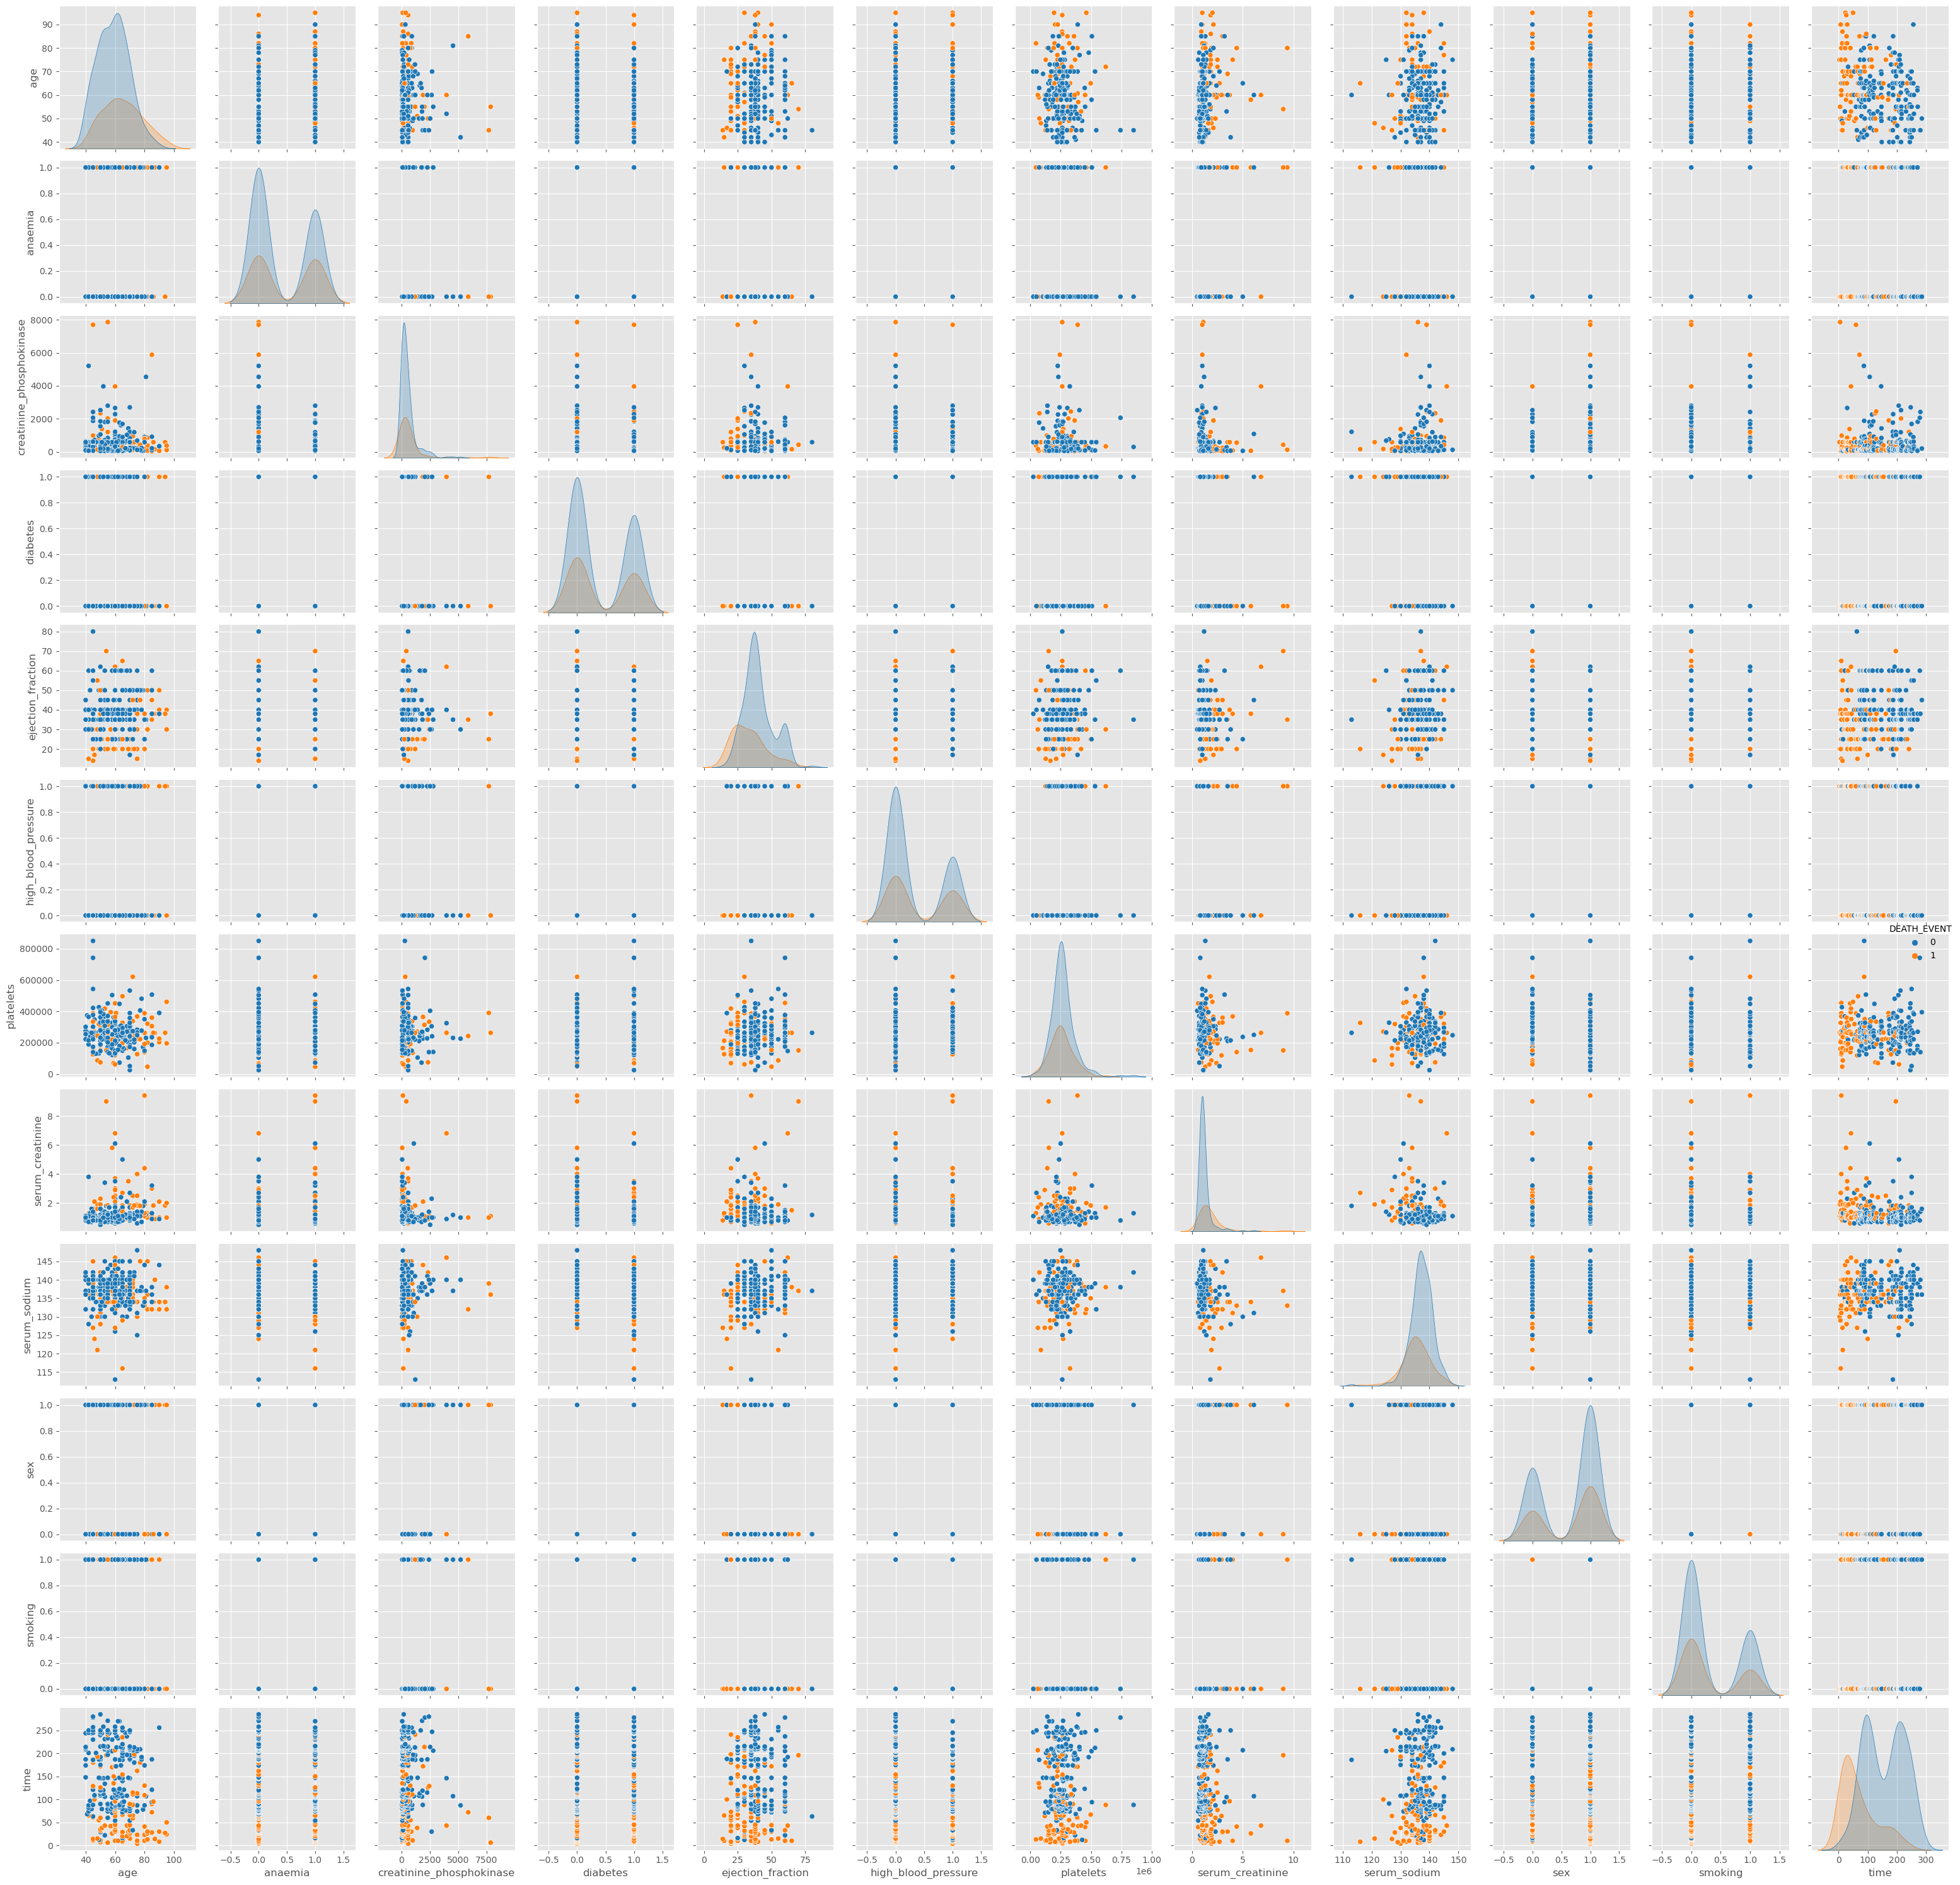

In [5]:
plt.figure(figsize=(30,20))
sns.pairplot(df, hue="DEATH_EVENT", palette="tab10")
plt.tight_layout()
plt.plot()

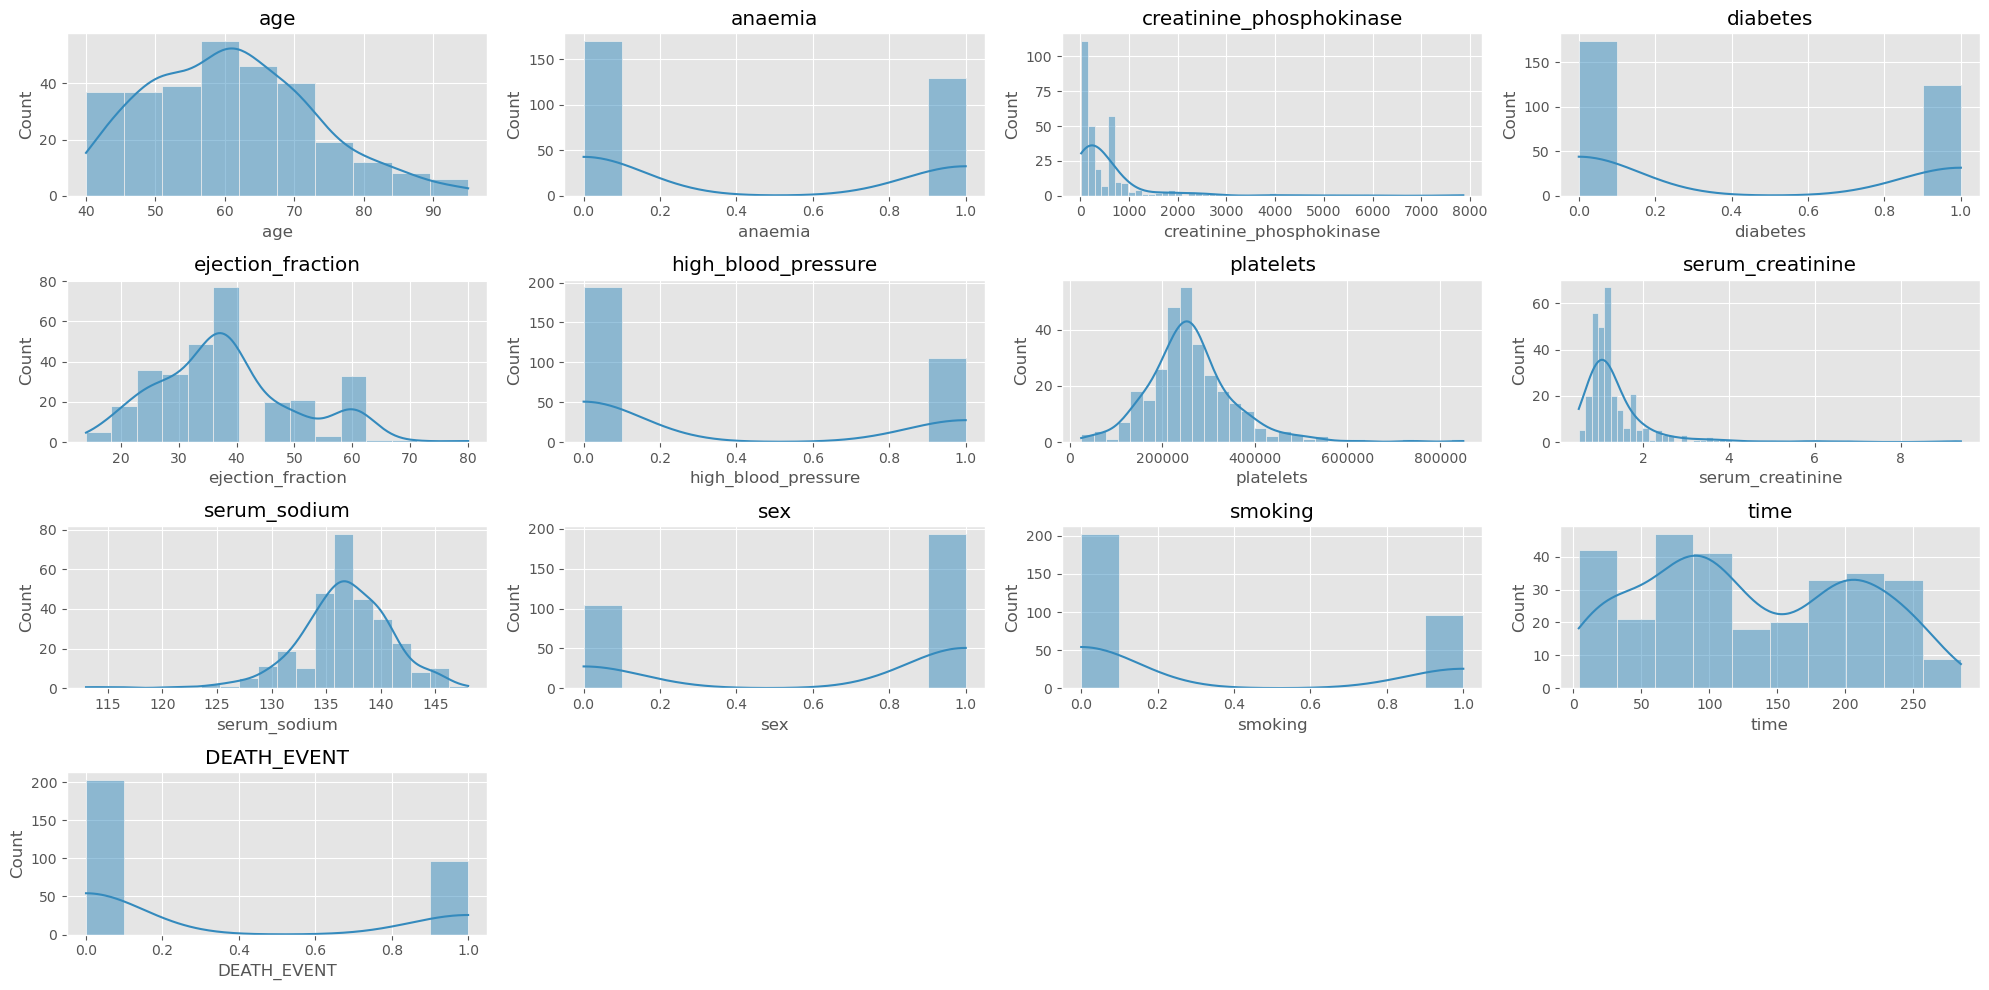

In [6]:
plt.figure(figsize=(20,10))
for i,col in enumerate(df.columns,1):
    plt.subplot(4,4,i)
    plt.title("{}".format(col))
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()

[]

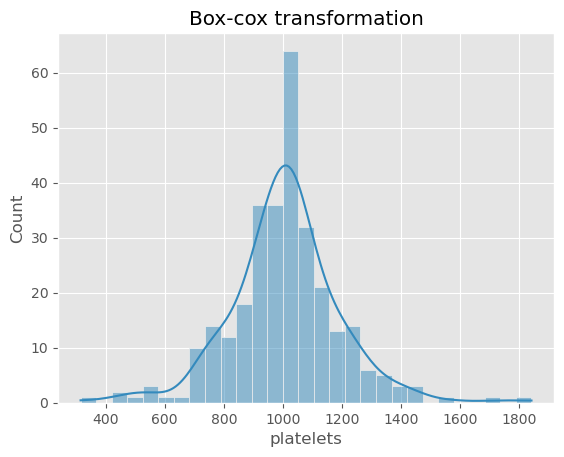

In [7]:
transformed_data = boxcox(df.platelets, 0.5)
# inv_boxcox(data, 0.5)
sns.histplot(transformed_data, kde=True)
plt.title("Box-cox transformation")
plt.plot()

### Modeling

Develop pipeline for pre-processing modeling with cross-validation and evaluation metrics comparison at the end. Potentially log result metrics into Mlflow. Simulate deployment into production process.

In [8]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from scipy.stats import uniform

In [9]:
# Split the data
from sklearn.model_selection import train_test_split

X = df.drop('DEATH_EVENT', axis=1)
y = df.DEATH_EVENT

# Shuffle and stratify by the target
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=42)

In [10]:
# Custom sk-learn transformer
class log_transform(BaseEstimator, TransformerMixin):
    '''Log scale plus one
    for the zero values.
    '''
    def fit(self, X, y=None):  # unable to log-log scale with sklearn
        return self
    def transform(self, X, y=None):
        X_log = np.log1p(X)
        return X_log

class boxcox_transform(BaseEstimator, TransformerMixin):
    '''Box-cox transformation 
    with lambda parameter.
    '''
    def fit(self, X, y=None):  # unable to log-log scale with sklearn
        return self
    def transform(self, X, y=None):
        X_log = boxcox(X, 2.5)  # arbitrary choice
        return X_log

In [11]:
# Pre-process part testing
df_train = df.drop('DEATH_EVENT', axis=1)  # testing purposes only
categ_col = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
num_col = df_train.columns.drop(categ_col)

pre_process = ColumnTransformer([
    ('Log transform', log_transform(), num_col),  # create custom transformer for X
    ('OHE', OneHotEncoder(sparse=True), categ_col),
    ], remainder='drop').fit_transform(df_train)

col_names = list(num_col) + ['anaemia_n', 'anaemia_y', 
                            'diabetes_n', 'diabetes_y', 
                            'hbp_n', 'hbp_y', 
                            'sex_m', 'sex_f', 
                            'smoking_n', 'smoking_y']
pre_process_test = pd.DataFrame(pre_process, columns=col_names)
pre_process_test

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia_n,anaemia_y,diabetes_n,diabetes_y,hbp_n,hbp_y,sex_m,sex_f,smoking_n,smoking_y
0,4.330733,6.368187,3.044522,12.487489,1.064711,4.875197,1.609438,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,4.025352,8.969796,3.663562,12.481274,0.741937,4.919981,1.945910,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,4.189655,4.990433,3.044522,11.995358,0.832909,4.867534,2.079442,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,3.931826,4.718499,3.044522,12.254868,1.064711,4.927254,2.079442,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,4.189655,5.081404,3.044522,12.697719,1.308333,4.762174,2.197225,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,4.143135,4.127134,3.663562,11.951187,0.741937,4.969813,5.602119,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
295,4.025352,7.507141,3.663562,12.506181,0.788457,4.941642,5.605802,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
296,3.828641,7.630947,4.110874,13.517106,0.587787,4.934474,5.631212,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
297,3.828641,7.789040,3.663562,11.849405,0.875469,4.948760,5.638355,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [20]:
# Custom ML pipeline
def search_cv():
    '''Outputs sk-learn object 
    to be fitted with training data,
    cross-validated with stratified folds.
    '''
    model = LogisticRegression(tol=1e-4, max_iter=500,
                            random_state=42)
    params = dict(C=np.logspace(-4, 4, 50),
                penalty=['l2', 'l1', 'elasticnet'],
                solver=['saga', 'lbfgs'])
    kf = model_selection.StratifiedKFold(n_splits=10, 
                                        shuffle=True)
    search = RandomizedSearchCV(model, params,
                                cv=kf,
                                random_state=42,
                                n_jobs=-1)
    return search

def model(X_train, y_train, X_test, y_test):
    pre_process = ColumnTransformer([
    ('Log transform', log_transform(), num_col),  # create custom transformer for X
    ('OHE', OneHotEncoder(sparse=False), categ_col),
    ], remainder='drop')  # leave only transformed columns

    pipe = Pipeline(
        steps=[
            ("pre_processing", pre_process),
            ("random_search", search_cv())
        ]
    )
    model = pipe.fit(X_train, y_train)

    score_seen = pipe.score(X_train, y_train)
    score_unseen = pipe.score(X_test, y_test)
    
    return model, score_unseen, score_seen  # best cv results

In [21]:
model, score_unseen, score_seen = model(X_train, y_train, X_test, y_test)
print("Score unseen data:", round(score_unseen, 2))
print("Score seen data:", round(score_seen, 2))

Score unseen data: 0.81
Score seen data: 0.88


In [22]:
# Report on unseen data
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.95      0.87        61
           1       0.83      0.52      0.64        29

    accuracy                           0.81        90
   macro avg       0.82      0.73      0.76        90
weighted avg       0.81      0.81      0.80        90



Low recall on unseen data. Model is failing to indicate true positives.

In [23]:
# Report on seen data
y_pred = model.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       142
           1       0.84      0.76      0.80        67

    accuracy                           0.88       209
   macro avg       0.86      0.85      0.85       209
weighted avg       0.87      0.88      0.87       209



Thoughts: In practice picking the best estimator from the RandomSearchCV() is partially overfitting and is proven to produce worse results in production. 

Andrew Ng workpaper on preventing overfitting from cross-validation data:
 - https://ai.stanford.edu/~ang/papers/cv-final.pdf

To do:
- Create standard train/test split before running the pipeline and evaluate the model on unseen data. - done
- Simulate real time increasing data and track performance
- Integrate Mlflow